In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.ticker
import scipy.signal
import scipy.optimize as op
import plasmapy
import matplotlib.cm as cm
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

# Simulation of electron hole

## Theory
- Schamel distribution
$$ f_e (v^2>2\phi) = \exp \left[ -\frac{\left(\sqrt{v^2-2\phi}+u\right)^2}{2} \right] $$
$$ f_e (v^2<2\phi) = \exp \left[ -\beta \left(\frac{v^2}{2}-\phi\right) - \frac{u^2}{2} \right] $$
其中$v$为孤波参考系中的速度，静系速度$v_0=v+u$
- 此分布下存在孤波
$$ \phi = \psi sech^4\left[\frac{x-u t}{4}\right]$$
- nonlinear dispersion relation
$$ 1+uZ(u) = -\frac{1}{2}Z'_r(u) = \frac{16}{15}b\sqrt{\psi}$$
- density distribution
$$n_e = 1 + \frac{d^2 \phi}{d x^2} = \psi\left[ sech^4(\frac{x-ut}{4})tanh^2(\frac{x-ut}{4}) -\frac{1}{4} sech^6(\frac{x-ut}{4}) \right]$$

In [2]:
def nonvec_f(vv,x):
    r = 0
    v_waveframe = vv
    w = v_waveframe**2-2*phi_theo(x)
    if v_waveframe<=-np.sqrt(2*phi_theo(x)):
        r=np.exp(-(-np.sqrt(w)+u)**2/2) 
    elif v_waveframe>np.sqrt(2*phi_theo(x)):
        r=np.exp(-( np.sqrt(w)+u)**2/2) 
    else:
        r = np.exp(-beta*(w/2)-u**2/2) 
    return r/np.sqrt(2*np.pi)
ff = np.vectorize(nonvec_f)
def psi_cal(u):
    r1 = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
    b = np.exp(-u**2)*(1-beta-u**2)/np.sqrt(np.pi)
    return 
def phi_theo(x):
    xp = (x-L/2)/delta
    return psi*np.cosh(xp)**(-4)
def test(u):
    return 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real

In [32]:
T = 1
k = 0.1
L = 2*np.pi/k

vmax = 5 # 速度最大值
nx = 500
nv = 500
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V,X=np.meshgrid(v,x)
dt = 0.02
max_steps  = 10000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1
d = 0.5
linear_time = 2*np.pi/np.sqrt(d)

path = '../../data/'
print(data_num)
print('k=',k)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)
print('linear time=',linear_time)

2
k= 0.1
limited time= 3135.3094682826136
real time =  200.0
linear time= 8.885765876316732


c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\matplotlib\ticker.py:2210: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\matplotlib\ticker.py:1095: RuntimeWarning: invalid value encountered in double_scalars
  coeff = np.round(x / b ** exponent)


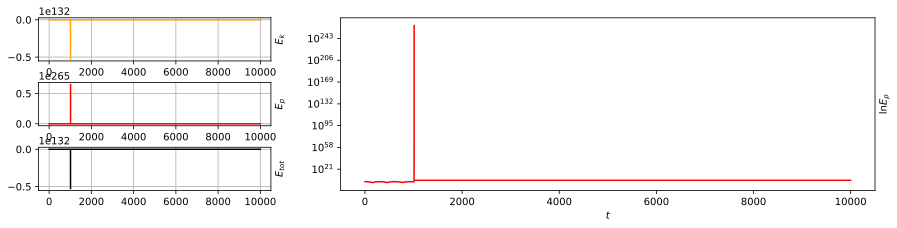

In [33]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [34]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [35]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

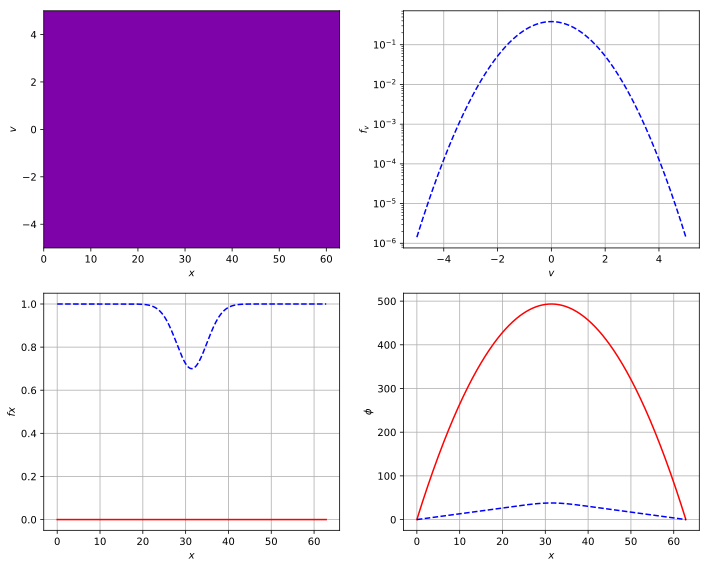

In [36]:
fig = plt.figure(figsize=(10, 8))

test_frame = 1
Z = f[test_frame]
fv = np.sum(Z, axis=0)*dx/L
Z_phi = phi[test_frame]
# Z[np.where(Z<1e-8)]=0
lvs_idx = np.linspace(-20,1,num=50)
lvs = 10**lvs_idx

ax1 = plt.subplot2grid((2, 2), (0, 0))
# ax1cm = ax1.contourf(X, V, Z, levels=lvs,norm=colors.LogNorm(vmin=lvs.min(),vmax=lvs.max()),cmap=cm.plasma)
ax1cm = ax1.contourf(X, V, Z, levels=20,cmap=cm.plasma)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$v$')
# ax1.set_ylim(4,6)

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(v, fv, color='red')
ax2.plot(v, fv0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$f_{v}$')
ax2.set_yscale('log')
ax2.grid()

ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(x, fx, color='red')
ax3.plot(x, fx0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$fx$')
ax3.grid()

ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.plot(x, Z_phi, color='red')
ax4.plot(x, phi[0],'--', color='blue')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$\phi$')
ax4.grid()

plt.tight_layout()

c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\matplotlib\contour.py:1562: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


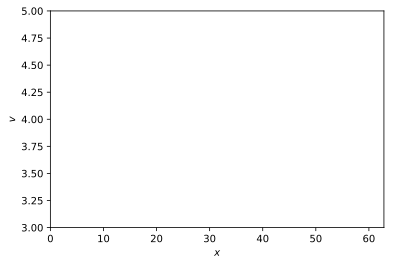

In [37]:
lvs_idx = np.linspace(-20,1,num=50)
lvs = 10**lvs_idx

plt.contourf(X, V, Z, levels=lvs,norm=colors.LogNorm(vmin=lvs.min(),vmax=lvs.max()),cmap=cm.plasma)
# plt.contourf(X, V, Z, levels=20,cmap=cm.plasma)
plt.xlabel(r'$x$')
plt.ylabel(r'$v$')
plt.ylim(3,5)
plt.show()

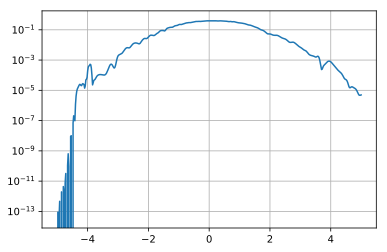

In [31]:
plt.plot(v,f[1][50])
plt.yscale('log')
plt.grid()
plt.show()